# Data Preparation

### Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

### Loading data

In [2]:
data = pd.read_csv('consumption_and_temperatures.csv')
data.head()

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
0,2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588,5.0,2674.838,5.5,2061.209,0.2,1609.089,3.9
1,2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209,4.1,2678.188,4.0,2045.436,0.1,1623.485,3.2
2,2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149,3.1,2678.341,3.7,2020.007,0.1,1634.128,2.7
3,2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042,2.3,2684.172,3.2,2021.920,0.1,1647.906,2.3
4,2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091,2.6,2733.345,2.7,2045.913,0.1,1679.176,2.3


### Preparing timestamp

In [3]:
data['timestamp'] = pd.to_datetime(data['timestamp']) # convert the index to a datetime index
data.set_index('timestamp', inplace=True) # set the timestamp as the index

### Splitting temperature and consumption

In [4]:
temp = data[['NO1_temperature', 'NO2_temperature', 'NO3_temperature', 'NO4_temperature', 'NO5_temperature']]
cons = data[['NO1_consumption', 'NO2_consumption', 'NO3_consumption', 'NO4_consumption', 'NO5_consumption']]

cons.head()

,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,
2017-05-01 00:00:00+00:00,3325.431995,3534.588,2674.838,2061.209,1609.089
2017-05-01 01:00:00+00:00,3344.690998,3560.209,2678.188,2045.436,1623.485
2017-05-01 02:00:00+00:00,3398.359002,3596.149,2678.341,2020.007,1634.128
2017-05-01 03:00:00+00:00,3430.220001,3594.042,2684.172,2021.920,1647.906
2017-05-01 04:00:00+00:00,3606.750000,3665.091,2733.345,2045.913,1679.176


### Plotting data

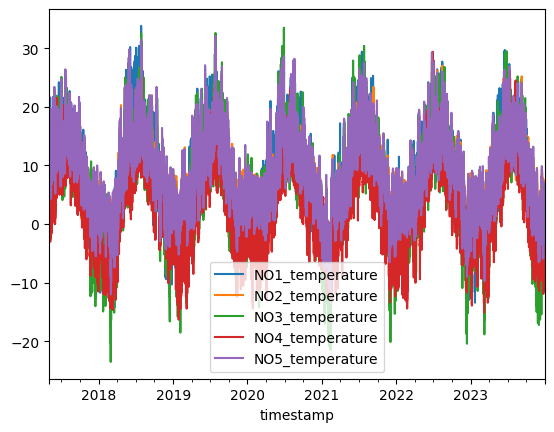

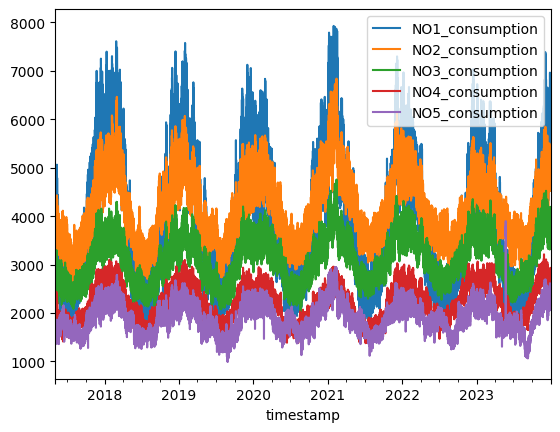

In [5]:
data.plot(y=temp.columns)
data.plot(y=cons.columns)
plt.show()

### Identifying and removing spikes

In [13]:
threshold = 3 # z-score threshold

#TODO: replace spikes with interpolation
def remove_spikes(data, threshold=3):
    tensor = torch.tensor(data.values)
    mean = tensor.mean()
    std = tensor.std()
    z_scores = (tensor - mean) / std
    spike_indices = (z_scores > threshold) | (z_scores < -threshold)
    tensor[spike_indices] = float('nan')
    return pd.DataFrame(tensor, index=data.index, columns=data.columns)

# temperature

temp_no_spikes = remove_spikes(temp, threshold)
cons_no_spikes = remove_spikes(cons, threshold)

### Plotting without spikes

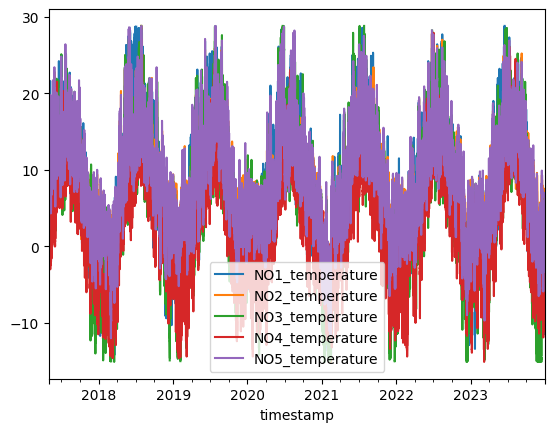

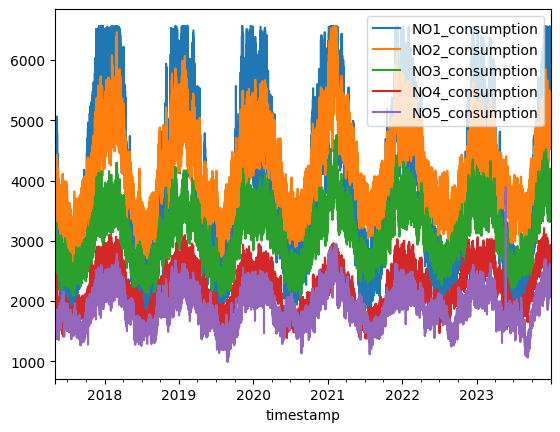

In [14]:
temp_no_spikes.plot(y=temp_no_spikes.columns)
cons_no_spikes.plot(y=cons_no_spikes.columns)
plt.show()